# (Re-)Imag(in)ing Price Trends

In [1]:
import numpy as np
import pandas as pd

IMG_H, IMG_W = 64, 60
IMG_SIZE = IMG_H * IMG_W  # 3840

def load_image_bin(dat_path):
    # read entire .dat file
    data = np.fromfile(dat_path, dtype=np.uint8)
    num_imgs = data.shape[0] // IMG_SIZE
    imgs = data.reshape(num_imgs, IMG_H, IMG_W)
    return imgs

def load_labels(feather_path):
    df = pd.read_feather(feather_path)
    return df


In [3]:
labels = load_labels('./monthly_20d/20d_month_has_vb_[20]_ma_1993_labels_w_delay.feather')
images_1993 = load_image_bin('./monthly_20d/20d_month_has_vb_[20]_ma_1993_images.dat')

df = labels

ret_col = "Ret_20d"
mask = ~df[ret_col].isna()
df_clean = df[mask].reset_index(drop=True)
X_1993 = images_1993[mask] 

ret20 = df_clean[ret_col].values 
y_1993 = (ret20 > 0).astype(np.int64)


Loaded images: (85644, 64, 60)


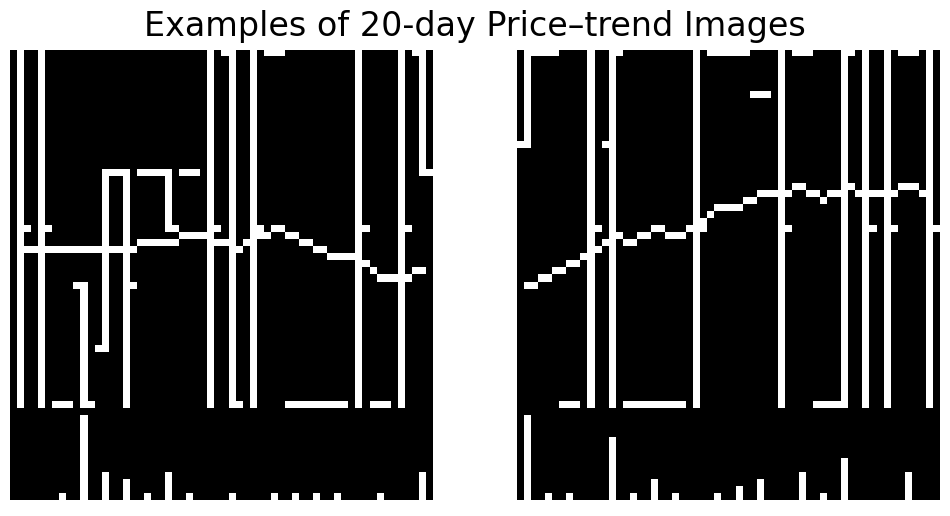

In [20]:
import numpy as np
import matplotlib.pyplot as plt
FONT_SIZE = 28

path = './monthly_20d/20d_month_has_vb_[20]_ma_1993_images.dat'
X = np.fromfile(path, dtype=np.uint8)

# reshape 成 (N, 64, 60)
N = X.size // (64 * 60)
X = X.reshape(N, 64, 60)

print("Loaded images:", X.shape)

k1, k2 = 2, 10
img1, img2 = X[k1], X[k2]

plt.figure(figsize=(12, 6))
plt.title("Examples of 20-day Price–trend Images", fontsize=24)
plt.axis('off')
# Left
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img2, cmap='gray', interpolation='nearest')

plt.savefig("examples.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [21]:
import os
import numpy as np
import pandas as pd

IMG_H, IMG_W = 64, 60
IMG_SIZE = IMG_H * IMG_W  # 64 * 60 = 3840

def load_one_year(base_dir, year, ret_col="Ret_20d", drop_nan=True):
    """
    加载某一年的图像和标签数据，并生成 0/1 标签。

    参数
    ----
    base_dir : str
        存放所有年份数据的目录，比如 r"F:\\Proj2\\img_data\\monthly_20d"
    year : int
        年份，比如 1993
    ret_col : str
        用哪一列的未来收益作为标签，默认 'Ret_20d'
    drop_nan : bool
        是否直接丢掉该列为 NaN 的样本（推荐 True）

    返回
    ----
    X : np.ndarray
        形状为 (N, 64, 60) 的图像数组，像素值在 [0, 255]，类型 uint8
    y : np.ndarray
        形状为 (N,) 的标签数组，0/1（如果 drop_nan=False，则可能包含 2 表示 NaN）
    df_clean : pd.DataFrame
        对应过滤后的标签 DataFrame（方便你之后按股票/日期分组等）
    """
    # 1. 拼接文件名
    img_file = os.path.join(
        base_dir, f"20d_month_has_vb_[20]_ma_{year}_images.dat"
    )
    label_file = os.path.join(
        base_dir, f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"
    )

    if not os.path.exists(img_file):
        raise FileNotFoundError(f"Image file not found: {img_file}")
    if not os.path.exists(label_file):
        raise FileNotFoundError(f"Label file not found: {label_file}")

    # 2. 读取标签 feather
    df = pd.read_feather(label_file)

    if ret_col not in df.columns:
        raise ValueError(f"{ret_col} not in label columns: {df.columns.tolist()}")

    # 3. 读取 .dat 二进制图像
    raw = np.fromfile(img_file, dtype=np.uint8)
    if raw.size % IMG_SIZE != 0:
        raise ValueError(
            f"File size {raw.size} is not divisible by {IMG_SIZE}. "
            f"Check IMG_H/IMG_W or file integrity."
        )
    num_imgs = raw.size // IMG_SIZE
    images = raw.reshape(num_imgs, IMG_H, IMG_W)  # (N, 64, 60)

    # 4. 对齐行数检查
    if len(df) != num_imgs:
        raise ValueError(
            f"Label rows ({len(df)}) != num images ({num_imgs}) for year {year}"
        )

    # 5. 构造标签
    ret = df[ret_col].to_numpy()  # 未来收益

    # 初始化为 2（NaN 占位）
    y = np.full(shape=ret.shape, fill_value=2, dtype=np.int64)

    # >0 为 1，<=0 为 0
    valid_mask = ~np.isnan(ret)
    y[(ret > 0) & valid_mask] = 1
    y[(ret <= 0) & valid_mask] = 0

    if drop_nan:
        # 丢掉 NaN（y==2）的样本
        non_nan_mask = (y != 2)
        X = images[non_nan_mask]
        y_clean = y[non_nan_mask]
        df_clean = df.loc[non_nan_mask].reset_index(drop=True)
    else:
        # 保留 NaN，把 y==2 留着，后面再自己处理
        X = images
        y_clean = y
        df_clean = df.copy()

    return X, y_clean, df_clean


In [22]:
# 1993-1999: train+val
Xs_train, ys_train = [], []
for year in range(1993, 2000):
    X_y, y_y, _ = load_one_year("./monthly_20d/", year) 
    Xs_train.append(X_y)
    ys_train.append(y_y)
X_train = np.concatenate(Xs_train, axis=0)
y_train = np.concatenate(ys_train, axis=0)

# 2000-2019: test
Xs_test, ys_test = [], []
for year in range(2000, 2020):
    X_y, y_y, _ = load_one_year("./monthly_20d/", year)
    Xs_test.append(X_y)
    ys_test.append(y_y)
X_test = np.concatenate(Xs_test, axis=0)
y_test = np.concatenate(ys_test, axis=0)



## DataLoader

In [23]:
import torch
from torch.utils.data import Dataset
import numpy as np

class PriceImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images        
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]           # (64, 60), uint8

        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # -> (1, 64, 60)

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]

        img = torch.from_numpy(img)          # float32
        label = torch.tensor(label, dtype=torch.long)

        return img, label


In [24]:
from torch.utils.data import DataLoader, random_split

def build_dataloaders(
    X_train, y_train, 
    X_test, y_test,
    batch_size=128,
    val_ratio=0.2,
    num_workers=0,    
):

    full_train_dataset = PriceImageDataset(X_train, y_train)

    n_total = len(full_train_dataset)
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_val

    train_dataset, val_dataset = random_split(
        full_train_dataset, [n_train, n_val],
        generator=torch.Generator().manual_seed(42)
    )

    test_dataset = PriceImageDataset(X_test, y_test)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,      
        pin_memory=False,    
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    return train_loader, val_loader, test_loader


## CNN

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PriceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # [B, 1, 64, 60]
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> [B, 32, 64, 60]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)                 # -> [B, 32, 32, 30]
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> [B, 64, 32, 30]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)                   # -> [B, 64, 16, 15]
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> [B, 128, 16, 15]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)                   # -> [B, 128, 8, 7]
        )

        # 128 * 8 * 7 = 7168
        self.fc1 = nn.Linear(128 * 8 * 7, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc_out = nn.Linear(256, 1)  # 输出一个 logit

        self._init_weights()

    def _init_weights(self):
        # Xavier 初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: [B, 1, 64, 60]
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        # [B, 128, 8, 7]
        x = x.view(x.size(0), -1)  # [B, 7168]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc_out(x).squeeze(1)  # [B]
        return logits


## Training

In [26]:
import torch
from torch import nn, optim

def binary_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total


def train_model(
    train_loader,
    val_loader,
    test_loader,
    num_epochs=50,
    lr=1e-5,
    weight_decay=0.0,
    patience=2,
    save_path=None,          # 新增: 用来保存 best 模型
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = PriceCNN().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    best_val_loss = float("inf")
    best_state_dict = None
    best_epoch = 0
    no_improve_epochs = 0

    for epoch in range(1, num_epochs + 1):
        # -------- Train --------
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)          # [B, 1, 64, 60]
            labels = labels.to(device).float()  # [B]

            optimizer.zero_grad()

            logits = model(images).squeeze(-1)  # 保证形状 [B]
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            acc_batch = binary_accuracy_from_logits(logits.detach(), labels.long())
            total_correct += acc_batch * batch_size

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # -------- Validation --------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float()

                logits = model(images).squeeze(-1)
                loss = criterion(logits, labels)

                batch_size = labels.size(0)
                val_loss += loss.item() * batch_size
                val_samples += batch_size
                val_acc_batch = binary_accuracy_from_logits(logits, labels.long())
                val_correct += val_acc_batch * batch_size

        val_loss = val_loss / val_samples
        val_acc = val_correct / val_samples
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch:02d} "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
        )

        # -------- Early stopping based on val_loss --------
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            no_improve_epochs = 0

            # 有提升就立刻保存一份 best ckpt
            if save_path is not None:
                torch.save(
                    {
                        "model_state_dict": best_state_dict,
                        "best_val_loss": best_val_loss,
                        "best_epoch": best_epoch,
                    },
                    save_path,
                )
                print(f"  Saved new best model to {save_path}")
        else:
            no_improve_epochs += 1
            print(f"  No improvement in val loss for {no_improve_epochs} epoch(s).")
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break

    # -------- Load best model (by val loss) --------
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        print(f"Loaded best model from epoch {best_epoch} with val loss = {best_val_loss:.4f}")

    # -------- Test evaluation --------
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            logits = model(images).squeeze(-1)
            loss = criterion(logits, labels)

            batch_size = labels.size(0)
            test_loss += loss.item() * batch_size
            test_samples += batch_size
            test_acc_batch = binary_accuracy_from_logits(logits, labels.long())
            test_correct += test_acc_batch * batch_size

    test_loss = test_loss / test_samples
    test_acc = test_correct / test_samples

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    history["test_loss"] = test_loss
    history["test_acc"] = test_acc
    history["best_epoch"] = best_epoch
    history["best_val_loss"] = best_val_loss

    return model, history


In [27]:
train_loader, val_loader, test_loader = build_dataloaders(
    X_train, y_train,
    X_test, y_test,
    batch_size=32, 
    val_ratio=0.2
)

In [15]:
model, history = train_model(
    train_loader,
    val_loader,
    test_loader,
    num_epochs=50,
    lr=3e-4,
    weight_decay=1e-4,
    patience=2,
    save_path = "price_cnn_20day_R20_best.ckpt"
)


Using device: cuda
Epoch 01 Train Loss: 0.6941 Acc: 0.5047 | Val Loss: 0.6925 Acc: 0.5149
  Saved new best model to price_cnn_20day_R20_best.ckpt
Epoch 02 Train Loss: 0.6893 Acc: 0.5336 | Val Loss: 0.6857 Acc: 0.5433
  Saved new best model to price_cnn_20day_R20_best.ckpt
Epoch 03 Train Loss: 0.6863 Acc: 0.5456 | Val Loss: 0.6850 Acc: 0.5472
  Saved new best model to price_cnn_20day_R20_best.ckpt
Epoch 04 Train Loss: 0.6855 Acc: 0.5473 | Val Loss: 0.6846 Acc: 0.5481
  Saved new best model to price_cnn_20day_R20_best.ckpt
Epoch 05 Train Loss: 0.6849 Acc: 0.5479 | Val Loss: 0.6842 Acc: 0.5496
  Saved new best model to price_cnn_20day_R20_best.ckpt
Epoch 06 Train Loss: 0.6847 Acc: 0.5491 | Val Loss: 0.6839 Acc: 0.5487
  Saved new best model to price_cnn_20day_R20_best.ckpt
Epoch 07 Train Loss: 0.6844 Acc: 0.5510 | Val Loss: 0.6846 Acc: 0.5481
  No improvement in val loss for 1 epoch(s).
Epoch 08 Train Loss: 0.6842 Acc: 0.5506 | Val Loss: 0.6841 Acc: 0.5503
  No improvement in val loss for

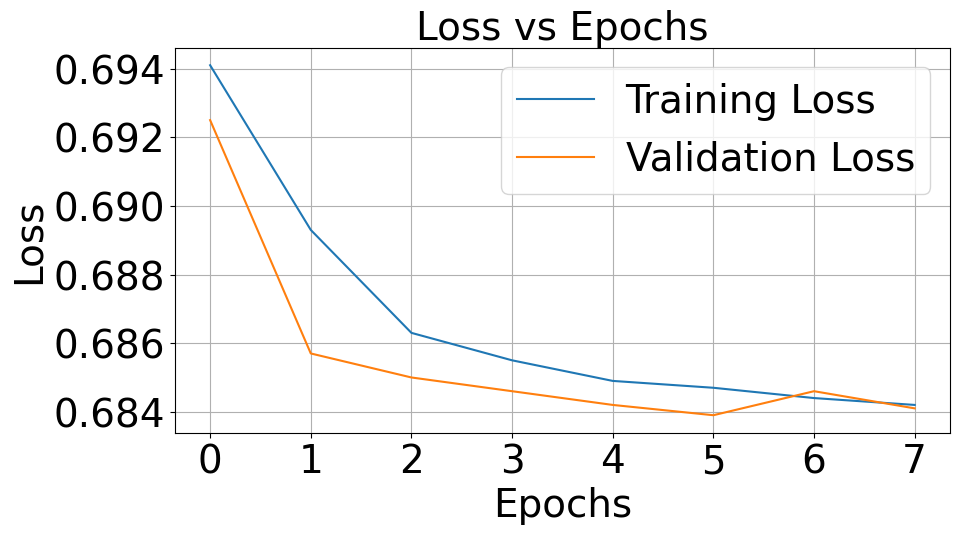

In [16]:
import matplotlib.pyplot as plt
FONT_SIZE = 28

plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label = "Training Loss")
plt.plot(history["val_loss"], label = "Validation Loss")
plt.title("Loss vs Epochs", fontsize=FONT_SIZE)
plt.xlabel("Epochs", fontsize=FONT_SIZE)
plt.ylabel("Loss", fontsize=FONT_SIZE)


plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)

plt.grid(True)
plt.legend(fontsize=FONT_SIZE)

plt.savefig("loss.pdf", dpi=300, bbox_inches='tight')

plt.show()


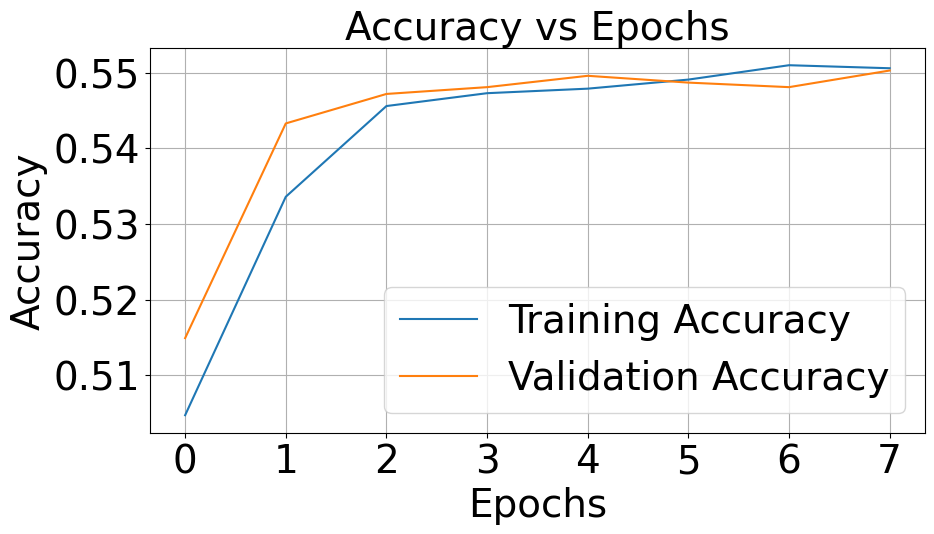

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")

plt.title("Accuracy vs Epochs", fontsize=FONT_SIZE)
plt.xlabel("Epochs", fontsize=FONT_SIZE)
plt.ylabel("Accuracy", fontsize=FONT_SIZE)

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)

plt.grid(True)
plt.legend(fontsize=FONT_SIZE)

plt.savefig("acc.pdf", dpi=300, bbox_inches='tight')

plt.show()


In [29]:
model = PriceCNN().to("cuda:0")
ckpt = torch.load("price_cnn_20day_R20_best.ckpt", map_location="cuda:0")
model.load_state_dict(ckpt['model_state_dict'])
model.eval()


PriceCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=7168, out_features=256, bias=True)

In [30]:
device = "cuda:0"

In [31]:
Xs_test, ys_test, metas_test = [], [], []
for year in range(2000, 2020):
    X_y, y_y, meta_y = load_one_year("./monthly_20d/", year)
    Xs_test.append(X_y)
    ys_test.append(y_y)
    metas_test.append(meta_y)

X_test = np.concatenate(Xs_test, axis=0)
y_test = np.concatenate(ys_test, axis=0)
meta_test = pd.concat(metas_test, ignore_index=True)


In [32]:
model.eval()
total_correct = 0
total = 0

with torch.no_grad():
    for xb, yb in val_loader:  
        xb = xb.to("cuda:0")
        yb = yb.to("cuda:0")

        logits = model(xb).squeeze(-1)      # [B]
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()

        total_correct += (preds == yb).sum().item()
        total += yb.size(0)

val_acc_reload = total_correct / total
print("val_acc from reloaded model =", val_acc_reload)


val_acc from reloaded model = 0.5487334522307771


In [33]:
test_dataset_full = PriceImageDataset(X_test, y_test)
test_loader_full = DataLoader(test_dataset_full, batch_size=256, shuffle=False)

proba = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader_full:
        xb = xb.to(device)               # xb shape: [B, 1, 64, 60]，和训练完全一样
        logits = model(xb)
        p = torch.sigmoid(logits).cpu().numpy().ravel()
        proba.append(p)

prob_up = np.concatenate(proba)

meta_test['prob_up'] = prob_up

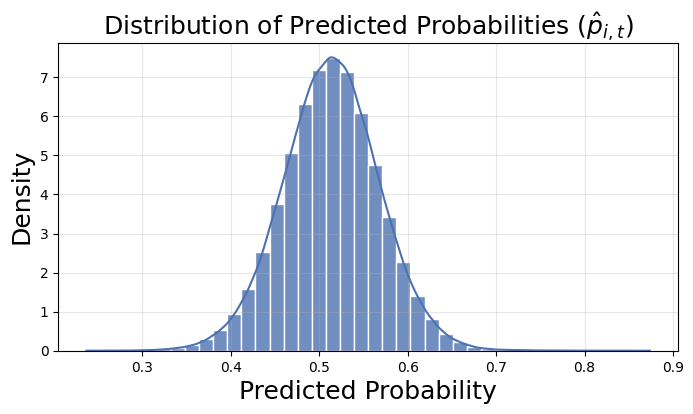

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
FONTSIZE=18
sns.histplot(prob_up, 
             bins=40, 
             kde=True, 
             color="#4C72B0", 
             edgecolor="white",
             alpha=0.8,
             stat="density")

plt.title("Distribution of Predicted Probabilities ($\\hat{p}_{i,t}$)", fontsize=FONTSIZE)
plt.xlabel("Predicted Probability", fontsize=FONTSIZE)
plt.ylabel("Density", fontsize=FONTSIZE)

plt.grid(alpha=0.3)

plt.savefig("Density.pdf", dpi=300, bbox_inches='tight')

plt.show()


## H-L Sharpe (I20/R20)

In [34]:
meta_test['future_return'] = meta_test['Ret_20d']    # <-- 用 horizon return
decile_returns = {d: [] for d in range(1, 11)}

for date, df_day in meta_test.groupby('Date'):     # rebalance date
    if len(df_day) < 50:
        continue

    df_day = df_day.copy()
    df_day['decile'] = pd.qcut(df_day['prob_up'], 10, labels=False) + 1

    for d in range(1, 11):
        r = df_day[df_day['decile']==d]['future_return'].mean()
        decile_returns[d].append(r)


In [50]:
hl = np.array(decile_returns[10]) - np.array(decile_returns[1])
annual_sharpe = hl.mean() / hl.std() * np.sqrt(12)  # monthly scaling
print("H-L Sharpe (I20/R20):", annual_sharpe)


H-L Sharpe (I20/R20): 2.4986901670801713


## rolling_sharpe_36m

In [51]:
import numpy as np
import pandas as pd

meta = meta_test.copy()
meta['future_return'] = meta['Ret_20d']

hl_list = []
hl_dates = []

for date, df_day in meta.groupby('Date'):   # Date 是每个月的 rebalancing 日期
    if len(df_day) < 50:
        continue

    df_day = df_day.copy()
    df_day['decile'] = pd.qcut(df_day['prob_up'], 10, labels=False) + 1

    ret_high = df_day[df_day['decile'] == 10]['future_return'].mean()
    ret_low  = df_day[df_day['decile'] == 1]['future_return'].mean()
    hl_t = ret_high - ret_low

    hl_list.append(hl_t)
    hl_dates.append(date)

hl_series = pd.Series(hl_list, index=pd.to_datetime(hl_dates)).sort_index()

def sharpe_annualized(x):
    if x.std() == 0:
        return np.nan
    return x.mean() / x.std() * np.sqrt(12)

rolling_sharpe = hl_series.rolling(window=36, min_periods=24).apply(sharpe_annualized, raw=False)



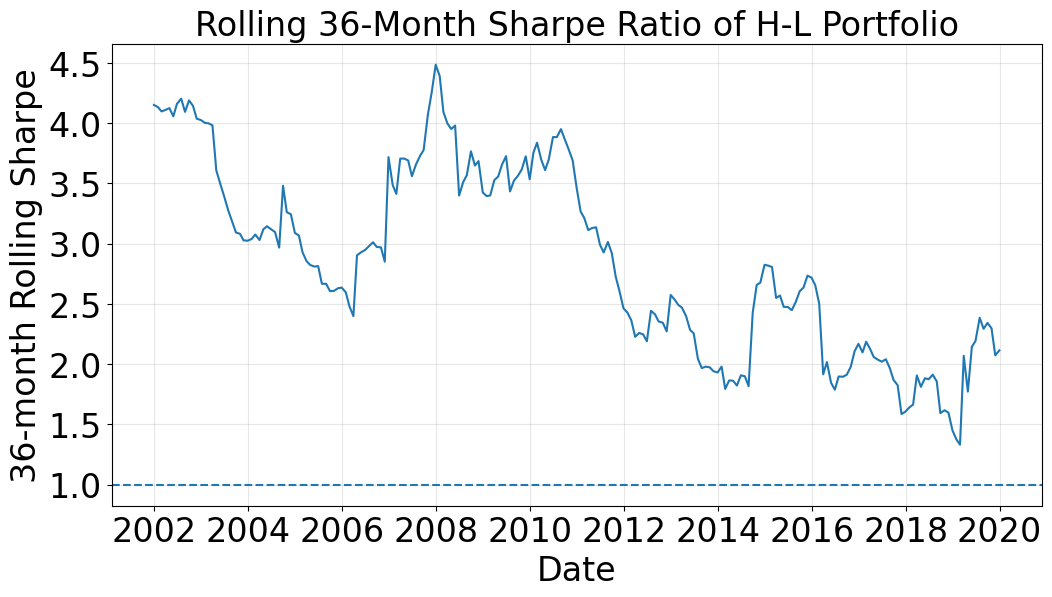

In [60]:
import matplotlib.pyplot as plt

FONT_SIZE = 24

plt.figure(figsize=(12, 6))
plt.plot(rolling_sharpe.index, rolling_sharpe.values)

plt.axhline(1.0, linestyle='--')  # 参考线 Sharpe=1
plt.xlabel("Date", fontsize=FONT_SIZE)
plt.ylabel("36-month Rolling Sharpe", fontsize=FONT_SIZE)
plt.title("Rolling 36-Month Sharpe Ratio of H-L Portfolio", fontsize=FONT_SIZE)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)

plt.savefig("./rolling_sharpe_36m.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [36]:
corr = np.corrcoef(meta_test['prob_up'], meta_test['future_return'])[0, 1]
print("corr(prob_up, Ret_20d) =", corr)


corr(prob_up, Ret_20d) = 0.052430059066984606


## decile_mean_returns

In [52]:
decile_returns = {d: [] for d in range(1, 11)}
period_dates = []  

for date, df_day in meta_test.sort_values('Date').groupby('Date'):
    if len(df_day) < 50:
        continue

    df_day = df_day.copy()
    df_day['decile'] = pd.qcut(df_day['prob_up'], 10, labels=False) + 1

    period_dates.append(date)

    for d in range(1, 11):
        r = df_day[df_day['decile'] == d]['future_return'].mean()
        decile_returns[d].append(r)

period_dates = np.array(period_dates)


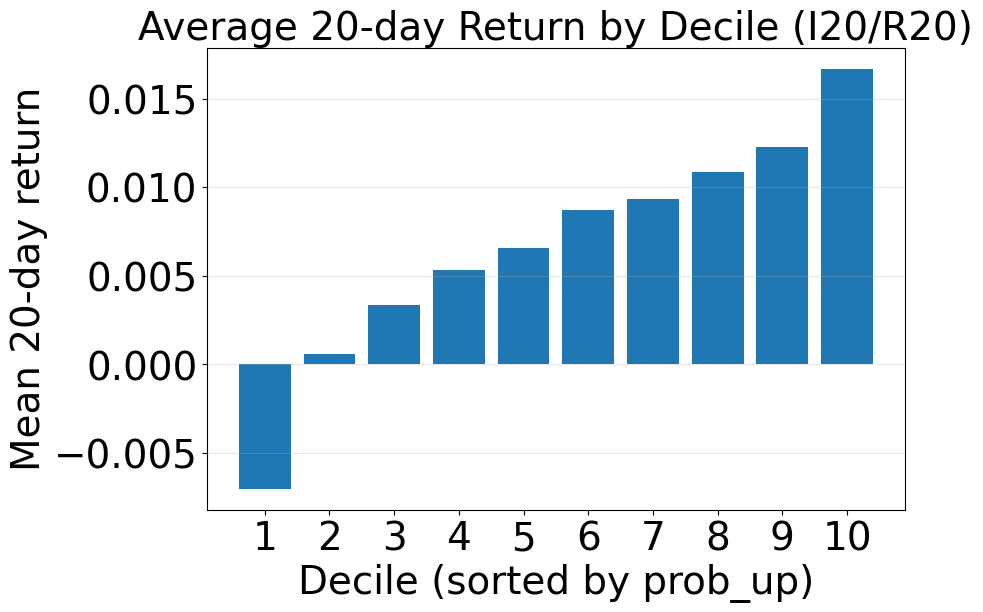

In [38]:
mean_ret_by_decile = [np.mean(decile_returns[d]) for d in range(1, 11)]

plt.figure(figsize=(9, 6))
plt.bar(range(1, 11), mean_ret_by_decile)
plt.xlabel("Decile (sorted by prob_up)", fontsize=FONT_SIZE)
plt.ylabel("Mean 20-day return", fontsize=FONT_SIZE)
plt.title("Average 20-day Return by Decile (I20/R20)", fontsize=FONT_SIZE)
plt.xticks(range(1, 11))
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)

plt.grid(True, axis='y', alpha=0.3)
plt.savefig("decile_mean_returns.pdf", dpi=300, bbox_inches='tight')

plt.show()


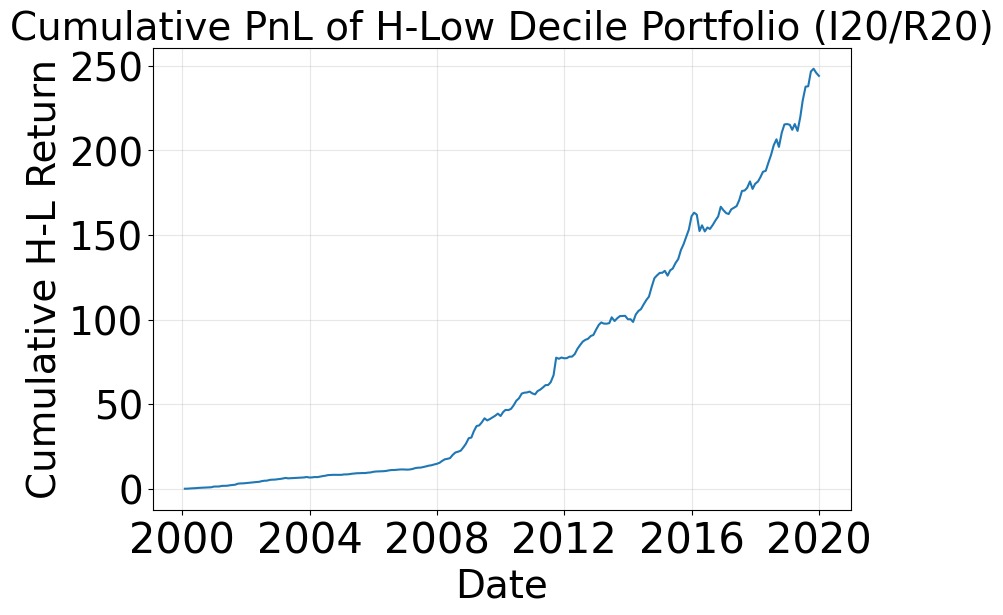

In [39]:
ret_high = np.array(decile_returns[10])
ret_low = np.array(decile_returns[1])
hl = ret_high - ret_low  
cum_hl = np.cumprod(1 + hl) - 1.0    

plt.figure(figsize=(9, 6))
plt.plot(period_dates, cum_hl)
plt.xlabel("Date", fontsize=FONT_SIZE)
plt.ylabel("Cumulative H-L Return", fontsize=FONT_SIZE)
plt.title("Cumulative PnL of H-Low Decile Portfolio (I20/R20)", fontsize=FONT_SIZE)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=30)
plt.yticks(fontsize=FONT_SIZE)

plt.savefig("hl_cumulative.pdf", dpi=300, bbox_inches='tight')

plt.show()


In [40]:
hl_mean = hl.mean()
hl_std = hl.std()
hl_sharpe_annual = hl_mean / hl_std * np.sqrt(12)   # 月频 → 年化

print("H-L Sharpe (I20/R20, recomputed):", hl_sharpe_annual)


H-L Sharpe (I20/R20, recomputed): 2.4986901670801713


In [42]:
N = 3000   
def topN_each_month(df, N):
    dfs = []
    for month, dfm in df.groupby("Month"):
        df_top = dfm.sort_values("MarketCap", ascending=False).head(N)
        dfs.append(df_top)
    return pd.concat(dfs)

meta_test['Date'] = pd.to_datetime(meta_test['Date'])
meta_test['Month'] = meta_test['Date'].dt.to_period('M')
meta_fixed = topN_each_month(meta_test, N=5000)  

## turnover

In [43]:
turnovers = []
prev_d1 = None
prev_d10 = None

for month, df_month in meta_fixed.groupby("Month"):
    df_day = df_month
    df_day = df_day.dropna(subset=['prob_up'])

    n = len(df_day)
    assert n == 5000, f"Unexpected stock count: {n}"

    k = n // 10  

    df_day = df_day.sort_values("prob_up")

    stocks = df_day['StockID'].astype(str).to_numpy()

    d1 = set(stocks[:k])
    d10 = set(stocks[-k:])

    if prev_d1 is not None:
        to_d1 = 1 - len(d1  & prev_d1) / k
        to_d10 = 1 - len(d10 & prev_d10) / k
        turnover = to_d1 + to_d10
        turnovers.append(turnover)

    prev_d1 = d1
    prev_d10 = d10

avg_turnover = np.mean(turnovers)
print("Average monthly turnover (H-L):", avg_turnover)


Average monthly turnover (H-L): 1.7428953974895396


In [44]:
meta_test.groupby("Month")["StockID"].nunique().describe()


count     240.000000
mean     6212.237500
std       751.641805
min      5388.000000
25%      5622.750000
50%      5721.500000
75%      6627.000000
max      8162.000000
Name: StockID, dtype: float64

In [45]:
meta_test[['EWMA_vol','future_return']].corr()


,EWMA_vol,future_return
EWMA_vol,1.000000,0.002021
future_return,0.002021,1.000000


In [ ]:
from scipy.stats import zscore
import numpy as np

df = meta_test.copy()

df['future_return'] = df['Ret_20d']

df['z_prob'] = df.groupby('Date')['prob_up'].transform(zscore)
df['z_vol']  = df.groupby('Date')['EWMA_vol'].transform(zscore)

df['stack_signal'] = df['z_prob'] -0.005 * df['z_vol']

decile_returns = {d: [] for d in range(1, 11)}

for date, df_day in df.groupby('Date'):
    if len(df_day) < 50:
        continue

    df_day = df_day.copy()
    df_day['decile'] = pd.qcut(df_day['stack_signal'], 10, labels=False) + 1

    for d in range(1, 11):
        r = df_day[df_day['decile']==d]['future_return'].mean()
        decile_returns[d].append(r)

hl = np.array(decile_returns[10]) - np.array(decile_returns[1])
stack_sharpe = hl.mean() / hl.std() * np.sqrt(12) 

print("Stacking Sharpe (with true EWMA vol):", stack_sharpe)


In [ ]:
# baseline
df_base = meta_test.copy()
df_base['future_return'] = df_base['Ret_20d']
df_base['z_prob'] = df_base.groupby('Date')['prob_up'].transform(zscore)

decile_returns_base = {d: [] for d in range(1, 11)}

for date, df_day in df_base.groupby('Date'):
    if len(df_day) < 50:
        continue

    df_day = df_day.copy()
    df_day['decile'] = pd.qcut(df_day['z_prob'], 10, labels=False) + 1

    for d in range(1, 11):
        r = df_day[df_day['decile']==d]['future_return'].mean()
        decile_returns_base[d].append(r)

hl_base = np.array(decile_returns_base[10]) - np.array(decile_returns_base[1])
sharpe_base = hl_base.mean() / hl_base.std() * np.sqrt(12)

print("Sharpe (prob only):", sharpe_base)

## EWMA-vol Stacking

In [118]:
lambdas = np.linspace(-0.5, 0.5, 41)
sharpes = []

for lam in lambdas:
    df['stack_signal'] = df['z_prob'] - lam * df['z_vol']
    decile_returns = {d: [] for d in range(1, 11)}

    for date, df_day in df.groupby('Date'):
        if len(df_day) < 50:
            continue
        df_day = df_day.copy()
        df_day['decile'] = pd.qcut(df_day['stack_signal'], 10, labels=False) + 1
        for d in range(1, 11):
            r = df_day[df_day['decile']==d]['future_return'].mean()
            decile_returns[d].append(r)

    hl = np.array(decile_returns[10]) - np.array(decile_returns[1])
    sharpe = hl.mean() / hl.std() * np.sqrt(12)
    sharpes.append(sharpe)

for lam, s in zip(lambdas, sharpes):
    print(lam, s)


-0.5 1.6878333094800666
-0.475 1.7083606306881858
-0.45 1.7424586130372242
-0.425 1.7848797675328563
-0.4 1.83237337560741
-0.375 1.8758507639855193
-0.35 1.9205051953964143
-0.32499999999999996 1.9950038648815664
-0.3 2.017652366141811
-0.275 2.0642518573261737
-0.25 2.091734634957017
-0.22499999999999998 2.140246076436122
-0.19999999999999996 2.184928926724888
-0.175 2.2521121796890626
-0.14999999999999997 2.274468337005446
-0.125 2.305236529228929
-0.09999999999999998 2.3454363388559964
-0.07499999999999996 2.363140684984878
-0.04999999999999999 2.40392127286596
-0.024999999999999967 2.446423347587111
0.0 2.4986901670801713
0.025000000000000022 2.5241868556714553
0.050000000000000044 2.565840593475823
0.07500000000000007 2.5982133163759618
0.10000000000000009 2.629278769229302
0.125 2.645395909992629
0.15000000000000002 2.6467912141406886
0.17500000000000004 2.641032672324253
0.20000000000000007 2.641447846762099
0.2250000000000001 2.618577483325173
0.25 2.581465581073495
0.275 2.55

0.15 2.6467912141406886


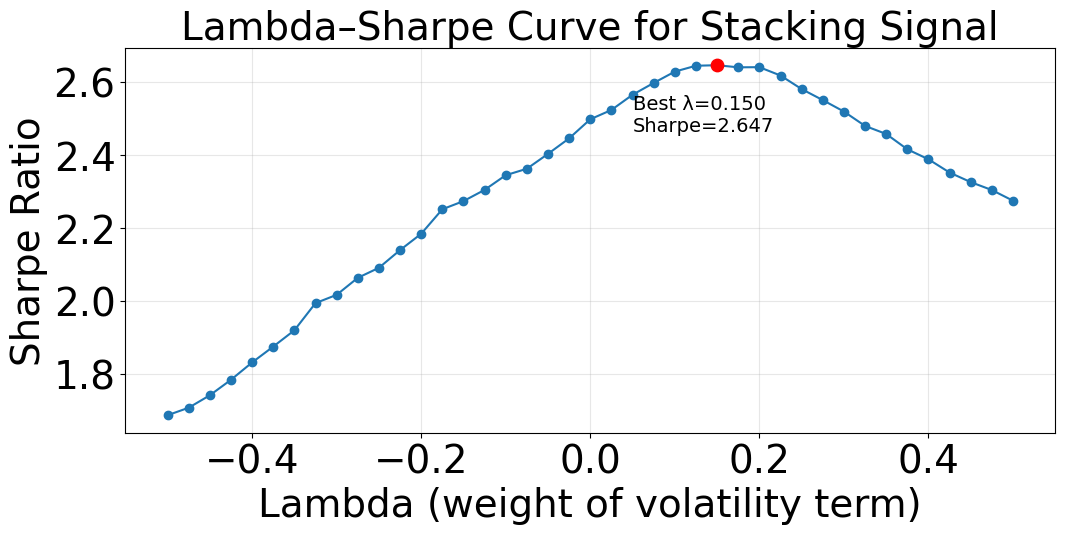

In [133]:
best_idx = np.argmax(sharpes)
best_lambda = lambdas[best_idx]
best_sharpe = sharpes[best_idx]

print(best_lambda, best_sharpe)

plt.figure(figsize=(12, 5))
plt.plot(lambdas, sharpes, marker="o")

plt.xlabel("Lambda (weight of volatility term)", fontsize=FONT_SIZE)
plt.ylabel("Sharpe Ratio", fontsize=FONT_SIZE)
plt.title("Lambda–Sharpe Curve for Stacking Signal", fontsize=FONT_SIZE)

plt.grid(True, alpha=0.3)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)

best_idx = np.argmax(sharpes)
best_lambda = lambdas[best_idx]
best_sharpe = sharpes[best_idx]

plt.scatter(best_lambda, best_sharpe, color="red", s=80, zorder=10)
plt.text(best_lambda - 0.1, best_sharpe - 0.18,
         f"Best λ={best_lambda:.3f}\nSharpe={best_sharpe:.3f}",
         fontsize=14)



plt.savefig("lambda_sharpe_curve.pdf", dpi=300, bbox_inches='tight')
plt.show()
